# Image Data Preprocessing

One of the most common task is to resize the images. This is due the Neural Networks expect certain input dimension of their models. Most common being (224,224,3)

In [3]:
# Lets begin by importing the neccessary libraries
import tensorflow as tf
import numpy as np
import matplotlib.pylab as plt
import pathlib

# And downloading our images dataset
data_dir = tf.keras.utils.get_file('flower_photos',
'https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz',
 untar=True)


# Brief Data Exploration

Lets look at the flowers dataset

In [4]:
!ls -lrt ~/.keras/datasets/flower_photos

total 824
-rw-r-----    1 ness  staff  418049 Feb  8  2016 LICENSE.txt
drwx------  801 ness  staff   25632 Feb 10  2016 tulips
drwx------  701 ness  staff   22432 Feb 10  2016 sunflowers
drwx------  643 ness  staff   20576 Feb 10  2016 roses
drwx------  900 ness  staff   28800 Feb 10  2016 dandelion
drwx------  635 ness  staff   20320 Feb 10  2016 daisy


### Choose a folder and see what types of images contains

In [6]:
!ls -lrt ~/.keras/datasets/flower_photos/roses | head -10

total 80232
-rw-r-----  1 ness  staff   33399 Jan 11  2016 7409458444_0bfc9a0682_n.jpg
-rw-r-----  1 ness  staff  102758 Jan 11  2016 7345657862_689366e79a.jpg
-rw-r-----  1 ness  staff   78640 Jan 11  2016 9337528427_3d09b7012b.jpg
-rw-r-----  1 ness  staff   32020 Jan 11  2016 7551637034_55ae047756_n.jpg
-rw-r-----  1 ness  staff  108384 Jan 11  2016 5736328472_8f25e6f6e7.jpg
-rw-r-----  1 ness  staff   40554 Jan 11  2016 3997609936_8db20b7141_n.jpg
-rw-r-----  1 ness  staff   24761 Jan 11  2016 3903276582_fe05bf84c7_n.jpg
-rw-r-----  1 ness  staff   39699 Jan 11  2016 3751835302_d5a03f55e8_n.jpg
-rw-r-----  1 ness  staff   26655 Jan 11  2016 3667366832_7a8017c528_n.jpg


### Lets create a function to plot an image

fig size: (3.2, 2.4)


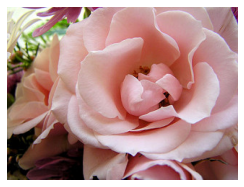

In [18]:
def display_image_in_actual_size(im_path):
    dpi = 100
    im_data= plt.imread(im_path)
    height, width, depth = im_data.shape
    fig_size =  width/float(dpi), height/float(dpi)
    print(f'fig size: {fig_size}')
    fig = plt.figure(figsize=fig_size)
    ax = fig.add_axes([0,0,1,1])
    ax.axis('off')
    ax.imshow(im_data, cmap='gray')
    plt.show()

IMAGE_PATH = "/Users/ness/.keras/datasets/flower_photos/roses/12240303_80d87f77a3_n.jpg"
display_image_in_actual_size(IMAGE_PATH)

fig size: (5.0, 3.33)


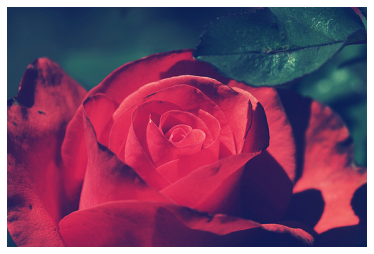

In [19]:
# here is another image
IMAGE_PATH = "/Users/ness/.keras/datasets/flower_photos/roses/5736328472_8f25e6f6e7.jpg"
display_image_in_actual_size(IMAGE_PATH)

# Reshaping (224x224) and creating Streaming Generator
To accomplish this you’ll use
- the `ImageDataGenerator` class: Creates a generator object. it has 2 important parameters: 
    - `rescale` : used for normalizing pizel values into a finite range
    - `validation_split`: subdivides a partition of data, such as for cross validation
- the `flow_from_directory` method: sets the directory from which the streaming will ocurr
    - `target_size`: helps you specify the desired dimension of each image
    - `batch_size`: specifies the number of samples in a batch of images (batch length)
    - `interpolation`: the metdho that will be used for the interpolation process: `nearest`, `biliniear`, `bicubic`



In [24]:
pixels =224
BATCH_SIZE = 32
IMAGE_SIZE = (pixels, pixels)
data_kwargs = dict(rescale=1./255, validation_split=.20)
dataflow_kwargs = dict(target_size=IMAGE_SIZE, batch_size=BATCH_SIZE,interpolation='bilinear')

# Create a generator object
valid_datagen = tf.keras.preprocessing.image.ImageDataGenerator(**data_kwargs)
# Specify the source directory (in this case the generator will only stream 20% of the data, and this is designated as a validation dataset)
valid_generator = valid_datagen.flow_from_directory(data_dir, subset='validation', shuffle=True, **dataflow_kwargs)

# We can use the same generator object for training data
train_datagen = valid_datagen
train_generator = train_datagen.flow_from_directory(data_dir, subset='training', shuffle=True, **dataflow_kwargs)

Found 731 images belonging to 5 classes.
Found 2939 images belonging to 5 classes.


In [25]:
# Inspect the output of the Generator
for image_batch, labels_batch in train_generator:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

(32, 224, 224, 3)
(32, 5)


# Extract the labels from the generator
### This is an important steps in preparation for the prediction

In [30]:
labels_idx = (train_generator.class_indices)
print(f'labels_idx: {labels_idx}')

idx_labels = dict((v, k) for k, v in labels_idx.items())
print(f'idx_labels: {idx_labels}')


labels_idx: {'daisy': 0, 'dandelion': 1, 'roses': 2, 'sunflowers': 3, 'tulips': 4}
idx_labels: {0: 'daisy', 1: 'dandelion', 2: 'roses', 3: 'sunflowers', 4: 'tulips'}


a typicial output from our classification model would be a numpy array like:

`(0.7, 0.1, 0.1, 0.05, 0.05)`

The position with the highest probability value is the first element. Map this index to the first key in `idx_labels`—in this case, `daisy`. This is how you capture the results of the prediction

### Save the idx_labels dictionary, it will come handy in the future

In [34]:
import pickle

# save the idx_labels
with open('prediction_lookup.pickle', 'wb') as handle:
    pickle.dump(idx_labels, handle, protocol=pickle.HIGHEST_PROTOCOL)

# This is how you load it back
with open('prediction_lookup.pickle', 'rb') as handle:
    lookup = pickle.load(handle)



# Training the model

### we have finished the pre-processing stage, next steps will be an extra

In [36]:
import tensorflow_hub as hub
NUM_CLASSES = 5
mdl = tf.keras.Sequential([tf.keras.layers.InputLayer(input_shape=IMAGE_SIZE + (3,)),
    hub.KerasLayer("https://tfhub.dev/google/imagenet/resnet_v1_101/feature_vector/4", 
    trainable=False),
    tf.keras.layers.Dense(NUM_CLASSES, activation='softmax',name = 'custom_class')])

mdl.build([None, 224, 224, 3])

ModuleNotFoundError: No module named 'tensorflow_hub'